# Evaluate the enrichment of Decipher shared phenotype patients on our ASD-CHD interactome

In [1]:
import matplotlib
matplotlib.use('TkAgg')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random

import community

from scipy.stats import mannwhitneyu

import mygene
mg = mygene.MyGeneInfo()

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'sans-serif')

sns.set_style('white')

import sys

import visJS2jupyter.visJS_module
import visJS2jupyter.visualizations

% matplotlib inline

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

# Load the ASD-CHD results, and print out comma separated gene names for pasting into DECIPHER

In [3]:

dec_AC_df = pd.read_excel('../../manuscript/tables_18_02/G_ASD_CHD_GIANT_p2nodes_180313.xlsx',sheetname='G_ASD_CHD_GIANT_p2nodes',
                         index_col='gene')
dec_A_df = pd.read_excel('../../manuscript/tables_18_02/ASD_CHD_zscore_separate.xlsx',sheetname='ASD_zscore')
dec_C_df = pd.read_excel('../../manuscript/tables_18_02/ASD_CHD_zscore_separate.xlsx',sheetname='CHD_zscore')

# load the ASD-EPI results, and pring out comma separated gene names for pasting into DECIPHER
dec_AE_df = pd.read_excel('../../manuscript/tables_18_02/G_ASD_EPI_GIANT_p2nodes.xlsx',sheetname='G_ASD_EPI_GIANT_p2nodes')


include_seeds=False

if include_seeds==False:
    AC_genes = dec_AC_df[(dec_AC_df['ASD_HC']==0)&(dec_AC_df['CHD_HC']==0)]
    A_genes = dec_A_df[(dec_A_df['ASD_HC']==0)&(dec_A_df['CHD_HC']==0)]
    C_genes = dec_C_df[(dec_C_df['ASD_HC']==0)&(dec_C_df['CHD_HC']==0)]
    
    AE_genes = dec_AE_df[(dec_AE_df['ASD_HC']==0)&(dec_AE_df['EPI_HC']==0)]
    
else:
    AC_genes = dec_AC_df.copy()
    A_genes = dec_A_df.copy()
    C_genes = dec_C_df.copy()
    
    AE_genes = dec_AE_df.copy()
A_genes = A_genes.sort_values('z_ASD',ascending=False).index.tolist() # genes sorted by z_ASD
C_genes = C_genes.sort_values('z_CHD',ascending=False).index.tolist() # genes sorted by z_CHD
AC_genes = AC_genes.sort_values('z_both',ascending=False).index.tolist()

AE_genes = AE_genes.sort_values('z_both',ascending=False).index.tolist()


string_to_print = ''
for gene in AC_genes[0:300]:
    if type(gene)==np.unicode:
        if gene not in ['SMA4','SMA5','LOC441204','TRN3','CNJ11']: # build a list of genes which aren't recognized by decipher
            string_to_print+=str(gene)+', '
string_to_print

'IGKV4-1, CREB3L4, PPP1R3F, MSI2, STK24, ZNF398, KCNJ11, CCT8, DHX57, MLH3, ANKRD13D, ABCC8, ZNF317, JDP2, KREMEN2, MYL12B, PPP2CB, SH3BP5L, SETP4, MFHAS1, STRN3, COL4A3BP, NOTCH3, PLA2G1B, RPUSD3, EBF3, NDE1, ZNF227, CARD9, REL, WNT3, SMARCA2, ACE, NKAIN1, PSEN1, FAM110A, STRIP2, PCDHA11, EP300, PSENEN, PCDHA8, SPTAN1, CTNNB1, PTENP1, TAF4, MGA, VANGL2, NBPF10, ZFR, FYN, PELI2, TM4SF19, CSPP1, NOTCH2NL, RASA2, NRIP3, DYRK3, USP54, EPC1, RUFY2, LRCH3, ATE1, HEY1, BRPF3, FBXO42, CRK, DIP2B, PCDHA7, ZBTB20, WNK2, OPTN, DLG3, TMTC2, LRP2BP, ZNF652, SLC35E2B, SCGB1D2, FBXO17, BAIAP2L1, DHX32, SAMD1, INVS, PCDHGB2, ZSCAN21, EFNB3, CBY1, COL19A1, PHLPP1, SELENON, AP2B1, AEBP2, ZNF236, TLN1, ZNF669, LRRFIP1, PDHA2, TMTC3, KLHL2, KANSL1L, ZC3H7A, ATP8B1, ZMIZ1, FIGN, ADGRL1, TMEM167B, SPOP, NPPB, PIK3R1, PCDHGA3, FBXO46, CEP95, SBK1, SMCR8, CTTNBP2NL, VPS13D, ITGA1, BBX, ZNF44, STOX2, MARCH8, PODNL1, AGAP4, SNX25, RBPJ, PHF6, GPCPD1, KANSL3, PCDHA12, LUZP1, ARHGAP26, FAT1, SMARCA4, RYBP, FZD3,

In [4]:
# load the ASD-CHD low z-score genes, and print out comma separated gene names for pasting into DECIPHER
dec_rand_df = pd.read_excel('../../manuscript/tables_18_02/G_ASD_CHD_GIANT_p2nodes_180313.xlsx',sheetname='low_zscore_genes',
                        index_col='Randomly selected non-significant genes')
rand_genes_AC = dec_rand_df.index.tolist() # don't sort them so we preserve order from table

# load the ASD-EPI low z-score genes, and print out comma separated gene names for pasting into DECIPHER
dec_rand_df = pd.read_excel('../../manuscript/tables_18_02/G_ASD_EPI_GIANT_p2nodes.xlsx',sheetname='low_zscore_genes',
                        index_col='Randomly selected non-significant genes')
rand_genes_AE = dec_rand_df.index.tolist() # don't sort them so we preserve order from table

string_to_print = ''
for gene in rand_genes_AC[0:300]:
    if type(gene)==np.unicode:
        if gene not in ['KIR3DS1','LOC440792']: # build a list of genes which aren't recognized by decipher
            string_to_print+=str(gene)+', '
string_to_print

'RNF10, RNF13, MVB12B, ZNF708, ZC3H15, TCOF1, RAB40B, ITGA8, MYO3B, ATP2A2, ITGA5, RARRES1, PHLDA3, UFSP2, HRH4, HPCAL4, CHST5, IGF2R, ERICH1, ART1, ART3, BFAR, ATP1A2, MGRN1, SPHK1, DPT, CUEDC1, MCM10, THUMPD2, PHOX2A, CFH, CFB, SIDT2, SAGE1, SIX2, SHOX2, CHFR, RFX4, RFX5, NRXN2, XPNPEP1, PM20D2, KHDRBS2, DPYSL5, IGFBP1, IGFBP4, PMS2P3, TXNIP, MLF1, IFT140, CFHR1, STMN2, TMEM141, API5, HAS2, KIAA1191, ZMAT3, MYBL1, SYNDIG1, UXS1, KMT5C, KMT5A, CDR2L, B3GAT1, CLCN2, CLCN6, DNAJA4, AKT1, MAGEL2, NDRG3, TRAPPC6B, RNF130, CHML, ZNF581, ZNF589, COL4A6, CTPS2, HOXA11, TTYH1, ZNF324, NEMF, TDG, EIF2AK4, EREG, PLAUR, KIAA1522, LOX, PRKY, LPCAT3, ALOX5, PIGA, PIGB, CALCRL, PIGL, PIGM, TAX1BP3, RHPN1, OLR1, PDK4, ALPI, PTGS2, CEP128, EIF1AX, EIF1AY, NTRK3, DDIT3, DDIT4, BMP5, DR1, TERF2, RASSF4, CHD5, IL4R, PRKCE, AVP, PRKCZ, MPZ, MCPH1, GRPEL2, HELLS, C10orf95, PRKACA, BEX4, BEX3, TMEM164, FOXN1, GRIN2D, IFFO1, MFGE8, CDC73, SEMG2, AKAP6, EIF2A, TMEM170A, MCF2L, KBTBD6, TMEM132A, ALPK2, MGLL, 

In [5]:
# load the ASD-CHD results
dec_AC_df = pd.read_excel('../../manuscript/tables_18_02/G_ASD_CHD_GIANT_p2nodes_180313.xlsx',sheetname='G_ASD_CHD_GIANT_p2nodes',
                         index_col='gene')
dec_AC = dec_AC_df['number shared phenotype patients with a mutation in this gene in decipher database (DNV)'].dropna()
dec_AC = dec_AC.head(300) # check the top 300 so it is a round number
print(len(dec_AC))

dec_AC.head()

300


gene
IGKV4-1    0.0
CREB3L4    0.0
PPP1R3F    2.0
MSI2       1.0
STK24      1.0
Name: number shared phenotype patients with a mutation in this gene in decipher database (DNV), dtype: float64

In [6]:
# load the random results
dec_rand_df = pd.read_excel('../../manuscript/tables_18_02/G_ASD_CHD_GIANT_p2nodes_180313.xlsx',sheetname='low_zscore_genes',
                        index_col='Randomly selected non-significant genes')
dec_rand = dec_rand_df['number shared phenotype patients with a mutation in this gene in decipher database (DNV)'].dropna()
dec_rand = dec_rand.head(300) # check the top 300 so it is a round number
print(len(dec_rand))
dec_rand.head()

300


Randomly selected non-significant genes
RNF10     0.0
RNF13     1.0
MVB12B    1.0
ZNF708    0.0
ZC3H15    0.0
Name: number shared phenotype patients with a mutation in this gene in decipher database (DNV), dtype: float64

In [7]:
# try a binomial test (greater or less than a number)
nthresh=0
print(sum(dec_AC>nthresh))
print(sum(dec_rand>nthresh))
krand = sum(dec_rand>nthresh)/float(len(dec_rand))
print(krand)

from scipy.stats import binom_test
binom_test(sum(dec_AC>nthresh),n=len(dec_AC),p=krand)

181
151
0.5033333333333333


0.0005218178774582998

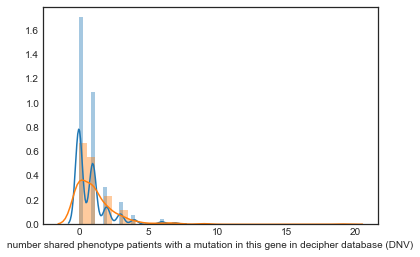

In [8]:
sns.distplot(dec_rand)
sns.distplot(dec_AC)

71


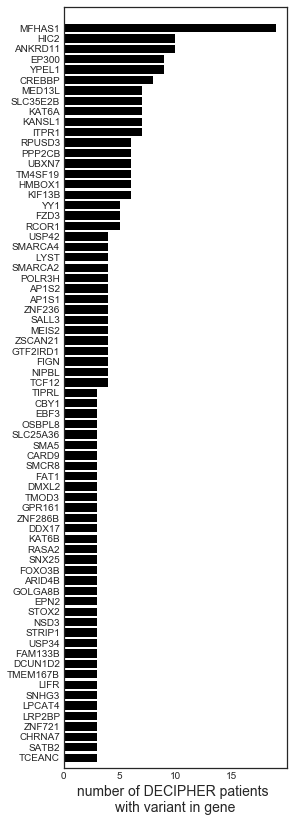

In [9]:
# plot the most frequent variants in the data
plt.figure(figsize=(4,14))
freq_vars = dec_AC_df['number shared phenotype patients with a mutation in this gene in decipher database (DNV)'].dropna().sort_values(ascending=False)
freq_vars = freq_vars[freq_vars>2]
plt.barh(range(len(freq_vars)),freq_vars.tolist(),color='k')
tmp =plt.yticks(np.arange(len(freq_vars)),freq_vars.index.tolist())
#plt.xticks([0,4,8,12,16,20])
plt.xlabel('number of DECIPHER patients \nwith variant in gene',fontsize=14)

plt.ylim([-2,len(freq_vars)])
ax = plt.gca()
ax.invert_yaxis()
print(len(freq_vars))
# plt.savefig('../../manuscript/figures_18_02/DECIPHER_frequent_variants_ASD_CHD_de_novo.pdf',bbox_inches='tight')

In [10]:
# make a dot plot for the frequency distribution
freq_vc = freq_vars.value_counts()
freq_vc.index.sort_values().tolist()

[3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 19.0]

Text(0,0.5,u'count')

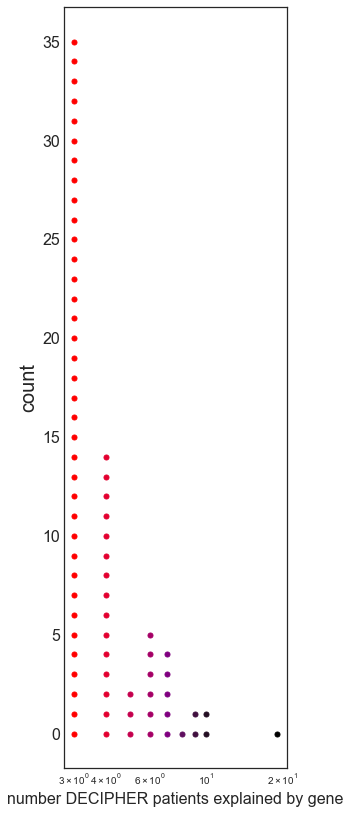

In [11]:
plt.figure(figsize=(4,14))
freq_count = -1

color_list = ['#ff0000','#e30030','#c5004d','#a50066','#800080','#5f0f5f','#411140','#240f23','#000000']

for freq in freq_vc.index.sort_values().tolist():
    freq_count+=1
    vc_temp = freq_vc.loc[freq]
    genes_temp = freq_vars[freq_vars==freq].index.tolist()
    for i in range(vc_temp):
        plt.semilogx(freq,i,'.',color=color_list[freq_count],ms=10)
        #plt.annotate(genes_temp[i],xy=(freq-.5,i+.5))
ax = plt.gca()
ax.tick_params(axis = 'y', which = 'major', labelsize = 16)

        
plt.xlabel('number DECIPHER patients explained by gene',fontsize=16)
plt.ylabel('count',fontsize=20)
# plt.savefig('../../manuscript/figures_18_02/GIANT_p2/DECIPHER_patients_recovered_ASD_CHD_dot_plot.pdf',bbox_inches='tight')

In [12]:
freq_vars[freq_vars==3]

gene
TIPRL       3.0
CBY1        3.0
EBF3        3.0
OSBPL8      3.0
SLC25A36    3.0
SMA5        3.0
CARD9       3.0
SMCR8       3.0
FAT1        3.0
DMXL2       3.0
TMOD3       3.0
GPR161      3.0
ZNF286B     3.0
DDX17       3.0
KAT6B       3.0
RASA2       3.0
SNX25       3.0
FOXO3B      3.0
ARID4B      3.0
GOLGA8B     3.0
EPN2        3.0
STOX2       3.0
NSD3        3.0
STRIP1      3.0
USP34       3.0
FAM133B     3.0
DCUN1D2     3.0
TMEM167B    3.0
LIFR        3.0
SNHG3       3.0
LPCAT4      3.0
LRP2BP      3.0
ZNF721      3.0
CHRNA7      3.0
SATB2       3.0
TCEANC      3.0
Name: number shared phenotype patients with a mutation in this gene in decipher database (DNV), dtype: float64

In [13]:
dec_AC_df.head()

,number shared phenotype patients with a mutation in this gene in decipher database (DNV),"number shared phenotype patients explained (with seeds, DNV)","num shared phenotype patients explained (no seeds, DNV)","number shared phenotype patients explained (with seeds, all variants)","num shared phenotype patients explained (no seeds, all variants)",ASD_CHD_DNV,ASD_HC,CHD_HC,z_ASD,z_CHD,z_both,xpos,ypos
gene,,,,,,,,,,,,,
CTTNBP2,NaN,0.0,NaN,1.0,NaN,0,1,0,47.350731,1.195295,27.753490,-1.538416,-0.377440
USP45,NaN,0.0,NaN,2.0,NaN,0,1,0,30.431117,0.066237,21.539680,-1.293820,-0.194478
SHANK3,NaN,4.0,NaN,9.0,NaN,0,1,0,24.601011,2.211072,16.876845,-1.587422,0.254440
NAA15,NaN,5.0,NaN,11.0,NaN,0,1,1,14.023218,9.630552,15.035266,-0.161088,1.309620
MYH6,NaN,5.0,NaN,12.0,NaN,0,0,1,0.865649,18.513572,14.645288,1.738860,0.469920


# Load the cumulative DECIPHER data and plot it, de novo constitutive only

In [15]:

dec_AC_df = pd.read_excel('../../manuscript/tables_18_02/G_ASD_CHD_GIANT_p2nodes_180313.xlsx',sheetname='G_ASD_CHD_GIANT_p2nodes',
                         index_col='gene')
dec_AC_df.head()
pat_exp_AC_withseeds = dec_AC_df.sort_values('z_both',ascending=False)['number shared phenotype patients explained (with seeds, DNV)'].dropna().tolist()
pat_exp_AC_noseeds = dec_AC_df.sort_values('z_both',ascending=False)['num shared phenotype patients explained (no seeds, DNV)'].dropna().tolist()

dec_A_df = pd.read_excel('../../manuscript/tables_18_02/ASD_CHD_zscore_separate.xlsx',sheetname='ASD_zscore')
pat_exp_A_noseeds = dec_A_df.sort_values('z_ASD',ascending=False)['ND-CD shared phenotype patients explained (no seeds)'].dropna().tolist()

dec_C_df = pd.read_excel('../../manuscript/tables_18_02/ASD_CHD_zscore_separate.xlsx',sheetname='CHD_zscore')
pat_exp_C_noseeds = dec_C_df.sort_values('z_CHD',ascending=False)['ND-CD shared phenotype patients explained (no seeds)'].dropna().tolist()

dec_rand_df = pd.read_excel('../../manuscript/tables_18_02/G_ASD_CHD_GIANT_p2nodes_180313.xlsx',sheetname='low_zscore_genes',
                        index_col='Randomly selected non-significant genes')
pat_exp_rand = dec_rand_df['num shared phenotype patients explained'].dropna().tolist()

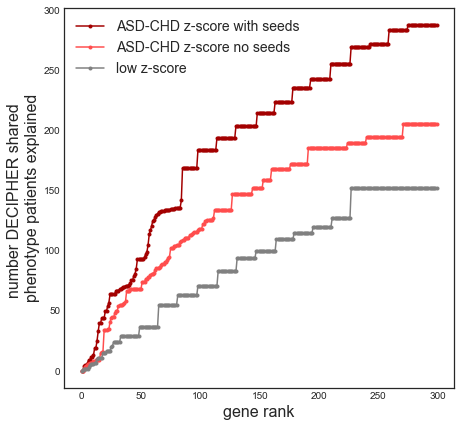

In [16]:
plt.figure(figsize=(7,7))
plt.plot(pat_exp_AC_withseeds,'.-',label='ASD-CHD z-score with seeds',color='#A30000')
plt.plot(pat_exp_AC_noseeds,'.-',label='ASD-CHD z-score no seeds',color='#FF4D4D')
# plt.plot(pat_exp_A_noseeds,'.-',label='ASD z-score no seeds')
# plt.plot(pat_exp_C_noseeds,'.-',label='CHD z-score no seeds')
plt.plot(pat_exp_rand,'.-',label='low z-score',color='gray')
plt.xlabel('gene rank',fontsize=16)
plt.ylabel('number DECIPHER shared \nphenotype patients explained',fontsize=16)

plt.legend(loc='best',fontsize=14)
#plt.savefig('../../manuscript/figures_18_02/DECIPHER_patients_recovered_ASD_CHD_de_novo.pdf',bbox_inches='tight')

# load the cumulative data and plot it, for all variants

In [17]:

dec_AC_df = pd.read_excel('../../manuscript/tables_18_02/G_ASD_CHD_GIANT_p2nodes_180313.xlsx',sheetname='G_ASD_CHD_GIANT_p2nodes')
dec_AC_df.head()
pat_exp_AC_withseeds = dec_AC_df.sort_values('z_both',ascending=False)['number shared phenotype patients explained (with seeds, all variants)'].dropna().tolist()
pat_exp_AC_noseeds = dec_AC_df.sort_values('z_both',ascending=False)['num shared phenotype patients explained (no seeds, all variants)'].dropna().tolist()

# dec_A_df = pd.read_excel('../../manuscript/tables_18_02/ASD_CHD_zscore_separate.xlsx',sheetname='ASD_zscore')
# pat_exp_A_noseeds = dec_A_df.sort_values('z_ASD',ascending=False)['ND-CD shared phenotype patients explained (no seeds)'].dropna().tolist()

# dec_C_df = pd.read_excel('../../manuscript/tables_18_02/ASD_CHD_zscore_separate.xlsx',sheetname='CHD_zscore')
# pat_exp_C_noseeds = dec_C_df.sort_values('z_CHD',ascending=False)['ND-CD shared phenotype patients explained (no seeds)'].dropna().tolist()

dec_rand_df = pd.read_excel('../../manuscript/tables_18_02/G_ASD_CHD_GIANT_p2nodes_180313.xlsx',sheetname='low_zscore_genes',
                        index_col='Randomly selected non-significant genes')
pat_exp_rand = dec_rand_df['num shared phenotype patients explained (all variants)'].dropna().tolist()

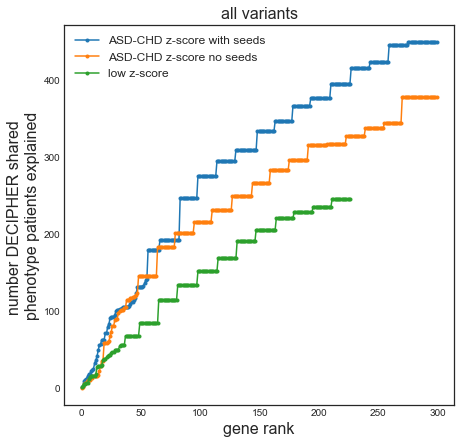

In [18]:
plt.figure(figsize=(7,7))
plt.plot(pat_exp_AC_withseeds,'.-',label='ASD-CHD z-score with seeds')
plt.plot(pat_exp_AC_noseeds,'.-',label='ASD-CHD z-score no seeds')
# plt.plot(pat_exp_A_noseeds,'.-',label='ASD z-score no seeds')
# plt.plot(pat_exp_C_noseeds,'.-',label='CHD z-score no seeds')
plt.plot(pat_exp_rand,'.-',label='low z-score')
plt.xlabel('gene rank',fontsize=16)
plt.ylabel('number DECIPHER shared \nphenotype patients explained',fontsize=16)
plt.title('all variants',fontsize=16)
plt.legend(loc='best',fontsize=12)

# Load the ASD-EPI data

In [19]:
# load the ASD-EPI results
dec_AE_df = pd.read_excel('../../manuscript/tables_18_02/G_ASD_EPI_GIANT_p2nodes.xlsx',sheetname='G_ASD_EPI_GIANT_p2nodes')
dec_AE = dec_AE_df['Number decipher variants in gene (ASD-EPI phenotype, all variants)'].dropna()
print(len(dec_AE))
dec_AE.head()

63


BCL2L11     0.0
RFFL        0.0
SLC25A42    0.0
MSI2        1.0
CREB3L4     0.0
Name: Number decipher variants in gene (ASD-EPI phenotype, all variants), dtype: float64

In [20]:
# load the random results
dec_rand_df = pd.read_excel('../../manuscript/tables_18_02/G_ASD_EPI_GIANT_p2nodes.xlsx',sheetname='low_zscore_genes',
                        index_col='Randomly selected non-significant genes')
dec_rand = dec_rand_df['number shared phenotype variants in this gene in decipher database (all variants)'].dropna()
print(len(dec_rand))
dec_rand.head()

66


Randomly selected non-significant genes
UBE2Q2    0.0
REM1      0.0
RNF17     0.0
ZNF703    0.0
SPN       5.0
Name: number shared phenotype variants in this gene in decipher database (all variants), dtype: float64

In [21]:
# try a binomial test (greater or less than a number)
nthresh=0
print(sum(dec_AE>nthresh))
print(sum(dec_rand>nthresh))
krand = sum(dec_rand>nthresh)/float(len(dec_rand))
print(krand)

from scipy.stats import binom_test
binom_test(sum(dec_AE>nthresh),n=len(dec_AE),p=krand)

11
7
0.10606060606060606


0.09694718930330162

In [34]:
# load the cumulative data and plot it, for all variants
dec_AE_df = pd.read_excel('../../manuscript/tables_18_02/G_ASD_EPI_GIANT_p2nodes.xlsx',sheetname='G_ASD_EPI_GIANT_p2nodes')
dec_AE_df.head()
#pat_exp_AC_withseeds = dec_AC_df.sort_values('z_both',ascending=False)['num shared phenotype patients explained (no seeds, all variants)'].dropna().tolist()
pat_exp_AE_noseeds = dec_AE_df.sort_values('z_both',ascending=False)['Number patients with variants, no seeds (ASD-EPI phenotype, all variants)'].dropna().tolist()

# dec_A_df = pd.read_excel('../../manuscript/tables_18_02/ASD_CHD_zscore_separate.xlsx',sheetname='ASD_zscore')
# pat_exp_A_noseeds = dec_A_df.sort_values('z_ASD',ascending=False)['ND-CD shared phenotype patients explained (no seeds)'].dropna().tolist()

# dec_C_df = pd.read_excel('../../manuscript/tables_18_02/ASD_CHD_zscore_separate.xlsx',sheetname='CHD_zscore')
# pat_exp_C_noseeds = dec_C_df.sort_values('z_CHD',ascending=False)['ND-CD shared phenotype patients explained (no seeds)'].dropna().tolist()

dec_rand_df = pd.read_excel('../../manuscript/tables_18_02/G_ASD_EPI_GIANT_p2nodes.xlsx',sheetname='low_zscore_genes',
                        index_col='Randomly selected non-significant genes')
pat_exp_rand = dec_rand_df[34].dropna().tolist()

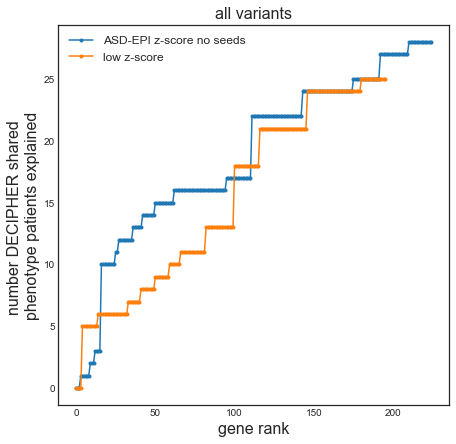

In [35]:
plt.figure(figsize=(7,7))
#plt.plot(pat_exp_AC_withseeds,'.-',label='ASD-CHD z-score with seeds')
plt.plot(pat_exp_AE_noseeds,'.-',label='ASD-EPI z-score no seeds')
# plt.plot(pat_exp_A_noseeds,'.-',label='ASD z-score no seeds')
# plt.plot(pat_exp_C_noseeds,'.-',label='CHD z-score no seeds')
plt.plot(pat_exp_rand,'.-',label='low z-score')
plt.xlabel('gene rank',fontsize=16)
plt.ylabel('number DECIPHER shared \nphenotype patients explained',fontsize=16)
plt.title('all variants',fontsize=16)
plt.legend(loc='best',fontsize=12)